Based on https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py

In [1]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [9]:
import torch
import torch.nn as nn

# DO CONVNETS.

image_shape = (4, 28, 28)
latent_shape = (16, 4, 4)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# Discriminator
D = nn.Sequential(
        # Input: batch, 4, 28, 28
        
        nn.Conv2d(4, 16, kernel_size=5, stride=1, padding=2), # => batch, 16, 28, 28
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2), # => batch, 16, 14, 14

        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), # => batch, 32, 7, 7
        nn.BatchNorm2d(32),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2), # => batch, 32, 7, 7

        Flatten(),

        nn.Linear(32*7*7, 64), # => batch, 64
        nn.LeakyReLU(0.2, True),
        #nn.Linear(64, 64), # => batch, 64
        #nn.LeakyReLU(0.2, True),
        nn.Linear(64, 1), # => batch, 1
        nn.Sigmoid()
)

# Generator
G = nn.Sequential(
        # next width or height := (prev_height - 1) * stride + kernel_size - padding * 2
    
        # Input: batch, 16, 4, 4 (latent_shape)
        nn.ConvTranspose2d(16, 256, kernel_size=3, stride=1), # b, 256, 6, 6
        nn.BatchNorm2d(256), # nn.utils.SpectralNorm(),
        nn.ReLU(True),

        nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=1), # b, 128, 13, 13
        nn.BatchNorm2d(128), # nn.utils.SpectralNorm(),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=0), # b, 32, 13, 13
        nn.BatchNorm2d(32), # nn.utils.SpectralNorm(),
        nn.ReLU(True),

        nn.ConvTranspose2d(32, 4, kernel_size=5, stride=1, padding=2), # b, 4, 28, 28
        # https://distill.pub/2016/deconv-checkerboard/
    
        nn.Tanh()
)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0004)

def printthings(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print(self.__class__.__name__ + ': ', input[0].size(), "=>", output.data.size())

handles = [m.register_forward_hook(printthings) for m in D.modules()] \
        + [m.register_forward_hook(printthings) for m in G.modules()]
print("GENERATOR")
g_out = G(torch.randn(10, *latent_shape))
print("DISCRIMINATOR")
d_out = D(g_out)
for handle in handles:
    handle.remove()

# Device setting
D = D.to(device)
G = G.to(device)

GENERATOR
ConvTranspose2d:  torch.Size([10, 16, 4, 4]) => torch.Size([10, 256, 6, 6])
BatchNorm2d:  torch.Size([10, 256, 6, 6]) => torch.Size([10, 256, 6, 6])
ReLU:  torch.Size([10, 256, 6, 6]) => torch.Size([10, 256, 6, 6])
ConvTranspose2d:  torch.Size([10, 256, 6, 6]) => torch.Size([10, 128, 13, 13])
BatchNorm2d:  torch.Size([10, 128, 13, 13]) => torch.Size([10, 128, 13, 13])
ReLU:  torch.Size([10, 128, 13, 13]) => torch.Size([10, 128, 13, 13])
ConvTranspose2d:  torch.Size([10, 128, 13, 13]) => torch.Size([10, 32, 28, 28])
BatchNorm2d:  torch.Size([10, 32, 28, 28]) => torch.Size([10, 32, 28, 28])
ReLU:  torch.Size([10, 32, 28, 28]) => torch.Size([10, 32, 28, 28])
ConvTranspose2d:  torch.Size([10, 32, 28, 28]) => torch.Size([10, 4, 28, 28])
Tanh:  torch.Size([10, 4, 28, 28]) => torch.Size([10, 4, 28, 28])
Sequential:  torch.Size([10, 16, 4, 4]) => torch.Size([10, 4, 28, 28])
DISCRIMINATOR
Conv2d:  torch.Size([10, 4, 28, 28]) => torch.Size([10, 16, 28, 28])
BatchNorm2d:  torch.Size([10

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


In [4]:
import h5py
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np

fname = 'dataset.hdf5'
dname = 'twitch_emotes'
with h5py.File(fname, 'r') as f:
    dataset = f[dname]
    preloaded_data = torch.Tensor(np.moveaxis(dataset[:200000], 3, 1)).to(device)
    print(preloaded_data.size())


torch.Size([200000, 4, 28, 28])


Epoch [0/50], Step [1/40], d_loss: 1.3996, g_loss: 0.6442, D(x): 0.57, D(G(z)): 0.57
Epoch [0/50], Step [2/40], d_loss: 1.4503, g_loss: 0.6237, D(x): 0.56, D(G(z)): 0.58
Epoch [0/50], Step [3/40], d_loss: 1.5120, g_loss: 0.5910, D(x): 0.55, D(G(z)): 0.59
Epoch [0/50], Step [4/40], d_loss: 1.5623, g_loss: 0.5616, D(x): 0.53, D(G(z)): 0.61
Epoch [0/50], Step [5/40], d_loss: 1.6014, g_loss: 0.5484, D(x): 0.52, D(G(z)): 0.61
Epoch [0/50], Step [6/40], d_loss: 1.6348, g_loss: 0.5384, D(x): 0.51, D(G(z)): 0.62
Epoch [0/50], Step [7/40], d_loss: 1.6547, g_loss: 0.5367, D(x): 0.50, D(G(z)): 0.62
Epoch [0/50], Step [8/40], d_loss: 1.6633, g_loss: 0.5391, D(x): 0.50, D(G(z)): 0.62
Epoch [0/50], Step [9/40], d_loss: 1.6652, g_loss: 0.5505, D(x): 0.49, D(G(z)): 0.61
Epoch [0/50], Step [10/40], d_loss: 1.6555, g_loss: 0.5677, D(x): 0.48, D(G(z)): 0.60
Epoch [0/50], Step [11/40], d_loss: 1.6467, g_loss: 0.5847, D(x): 0.47, D(G(z)): 0.59
Epoch [0/50], Step [12/40], d_loss: 1.6234, g_loss: 0.6096, D(x

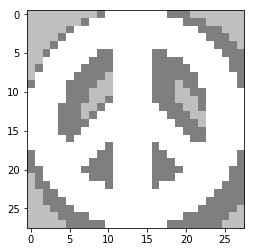

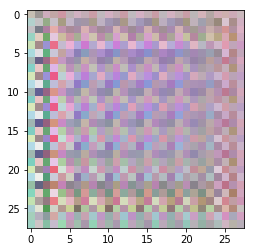

Epoch [1/50], Step [1/40], d_loss: 1.5619, g_loss: 0.7237, D(x): 0.43, D(G(z)): 0.51
Epoch [1/50], Step [2/40], d_loss: 1.5457, g_loss: 0.7441, D(x): 0.43, D(G(z)): 0.50
Epoch [1/50], Step [3/40], d_loss: 1.5294, g_loss: 0.7617, D(x): 0.42, D(G(z)): 0.49
Epoch [1/50], Step [4/40], d_loss: 1.5183, g_loss: 0.7734, D(x): 0.42, D(G(z)): 0.48
Epoch [1/50], Step [5/40], d_loss: 1.5066, g_loss: 0.7832, D(x): 0.42, D(G(z)): 0.47
Epoch [1/50], Step [6/40], d_loss: 1.4954, g_loss: 0.7924, D(x): 0.42, D(G(z)): 0.47
Epoch [1/50], Step [7/40], d_loss: 1.4885, g_loss: 0.7972, D(x): 0.42, D(G(z)): 0.47
Epoch [1/50], Step [8/40], d_loss: 1.4858, g_loss: 0.7940, D(x): 0.43, D(G(z)): 0.47
Epoch [1/50], Step [9/40], d_loss: 1.4868, g_loss: 0.7868, D(x): 0.43, D(G(z)): 0.47
Epoch [1/50], Step [10/40], d_loss: 1.4865, g_loss: 0.7784, D(x): 0.43, D(G(z)): 0.47
Epoch [1/50], Step [11/40], d_loss: 1.4936, g_loss: 0.7658, D(x): 0.43, D(G(z)): 0.48
Epoch [1/50], Step [12/40], d_loss: 1.5052, g_loss: 0.7499, D(x

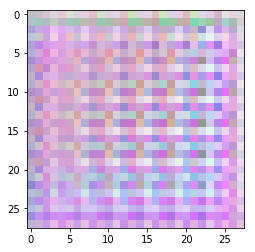

Epoch [2/50], Step [1/40], d_loss: 1.4765, g_loss: 0.7703, D(x): 0.44, D(G(z)): 0.48
Epoch [2/50], Step [2/40], d_loss: 1.4669, g_loss: 0.7842, D(x): 0.44, D(G(z)): 0.47
Epoch [2/50], Step [3/40], d_loss: 1.4573, g_loss: 0.7965, D(x): 0.44, D(G(z)): 0.47
Epoch [2/50], Step [4/40], d_loss: 1.4474, g_loss: 0.8078, D(x): 0.44, D(G(z)): 0.46
Epoch [2/50], Step [5/40], d_loss: 1.4316, g_loss: 0.8211, D(x): 0.44, D(G(z)): 0.45
Epoch [2/50], Step [6/40], d_loss: 1.4190, g_loss: 0.8345, D(x): 0.44, D(G(z)): 0.45
Epoch [2/50], Step [7/40], d_loss: 1.4069, g_loss: 0.8438, D(x): 0.44, D(G(z)): 0.44
Epoch [2/50], Step [8/40], d_loss: 1.3950, g_loss: 0.8485, D(x): 0.44, D(G(z)): 0.44
Epoch [2/50], Step [9/40], d_loss: 1.3889, g_loss: 0.8513, D(x): 0.44, D(G(z)): 0.44
Epoch [2/50], Step [10/40], d_loss: 1.3792, g_loss: 0.8553, D(x): 0.44, D(G(z)): 0.43
Epoch [2/50], Step [11/40], d_loss: 1.3698, g_loss: 0.8592, D(x): 0.45, D(G(z)): 0.43
Epoch [2/50], Step [12/40], d_loss: 1.3618, g_loss: 0.8620, D(x

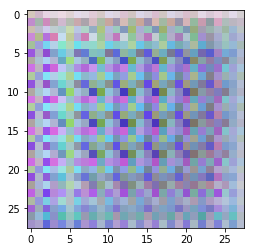

Epoch [3/50], Step [1/40], d_loss: 1.5434, g_loss: 0.6510, D(x): 0.47, D(G(z)): 0.54
Epoch [3/50], Step [2/40], d_loss: 1.5436, g_loss: 0.6591, D(x): 0.46, D(G(z)): 0.54
Epoch [3/50], Step [3/40], d_loss: 1.5495, g_loss: 0.6648, D(x): 0.46, D(G(z)): 0.53
Epoch [3/50], Step [4/40], d_loss: 1.5533, g_loss: 0.6707, D(x): 0.45, D(G(z)): 0.53
Epoch [3/50], Step [5/40], d_loss: 1.5568, g_loss: 0.6769, D(x): 0.45, D(G(z)): 0.53
Epoch [3/50], Step [6/40], d_loss: 1.5571, g_loss: 0.6823, D(x): 0.44, D(G(z)): 0.52
Epoch [3/50], Step [7/40], d_loss: 1.5562, g_loss: 0.6880, D(x): 0.44, D(G(z)): 0.52
Epoch [3/50], Step [8/40], d_loss: 1.5548, g_loss: 0.6947, D(x): 0.44, D(G(z)): 0.52
Epoch [3/50], Step [9/40], d_loss: 1.5512, g_loss: 0.7012, D(x): 0.44, D(G(z)): 0.51
Epoch [3/50], Step [10/40], d_loss: 1.5498, g_loss: 0.7069, D(x): 0.43, D(G(z)): 0.51
Epoch [3/50], Step [11/40], d_loss: 1.5441, g_loss: 0.7133, D(x): 0.43, D(G(z)): 0.51
Epoch [3/50], Step [12/40], d_loss: 1.5395, g_loss: 0.7224, D(x

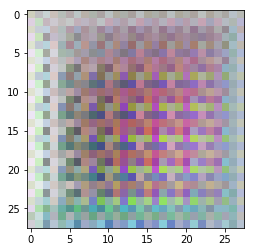

Epoch [4/50], Step [1/40], d_loss: 1.3552, g_loss: 0.8438, D(x): 0.46, D(G(z)): 0.44
Epoch [4/50], Step [2/40], d_loss: 1.3547, g_loss: 0.8506, D(x): 0.46, D(G(z)): 0.44
Epoch [4/50], Step [3/40], d_loss: 1.3494, g_loss: 0.8561, D(x): 0.46, D(G(z)): 0.43
Epoch [4/50], Step [4/40], d_loss: 1.3456, g_loss: 0.8599, D(x): 0.46, D(G(z)): 0.43
Epoch [4/50], Step [5/40], d_loss: 1.3368, g_loss: 0.8629, D(x): 0.46, D(G(z)): 0.43
Epoch [4/50], Step [6/40], d_loss: 1.3318, g_loss: 0.8641, D(x): 0.46, D(G(z)): 0.43
Epoch [4/50], Step [7/40], d_loss: 1.3293, g_loss: 0.8638, D(x): 0.46, D(G(z)): 0.43
Epoch [4/50], Step [8/40], d_loss: 1.3235, g_loss: 0.8626, D(x): 0.47, D(G(z)): 0.43
Epoch [4/50], Step [9/40], d_loss: 1.3200, g_loss: 0.8608, D(x): 0.47, D(G(z)): 0.43
Epoch [4/50], Step [10/40], d_loss: 1.3157, g_loss: 0.8577, D(x): 0.47, D(G(z)): 0.43
Epoch [4/50], Step [11/40], d_loss: 1.3116, g_loss: 0.8546, D(x): 0.48, D(G(z)): 0.43
Epoch [4/50], Step [12/40], d_loss: 1.3076, g_loss: 0.8519, D(x

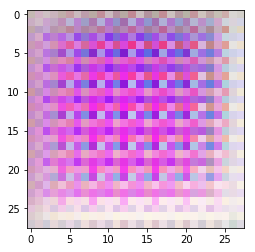

Epoch [5/50], Step [1/40], d_loss: 1.3853, g_loss: 0.6042, D(x): 0.58, D(G(z)): 0.56
Epoch [5/50], Step [2/40], d_loss: 1.4030, g_loss: 0.5941, D(x): 0.58, D(G(z)): 0.57
Epoch [5/50], Step [3/40], d_loss: 1.4230, g_loss: 0.5825, D(x): 0.58, D(G(z)): 0.58
Epoch [5/50], Step [4/40], d_loss: 1.4461, g_loss: 0.5742, D(x): 0.58, D(G(z)): 0.59
Epoch [5/50], Step [5/40], d_loss: 1.4620, g_loss: 0.5709, D(x): 0.57, D(G(z)): 0.59
Epoch [5/50], Step [6/40], d_loss: 1.4670, g_loss: 0.5751, D(x): 0.57, D(G(z)): 0.59
Epoch [5/50], Step [7/40], d_loss: 1.4640, g_loss: 0.5837, D(x): 0.56, D(G(z)): 0.59
Epoch [5/50], Step [8/40], d_loss: 1.4577, g_loss: 0.5963, D(x): 0.56, D(G(z)): 0.58
Epoch [5/50], Step [9/40], d_loss: 1.4416, g_loss: 0.6123, D(x): 0.56, D(G(z)): 0.57
Epoch [5/50], Step [10/40], d_loss: 1.4250, g_loss: 0.6312, D(x): 0.55, D(G(z)): 0.56
Epoch [5/50], Step [11/40], d_loss: 1.4062, g_loss: 0.6521, D(x): 0.55, D(G(z)): 0.55
Epoch [5/50], Step [12/40], d_loss: 1.3943, g_loss: 0.6704, D(x

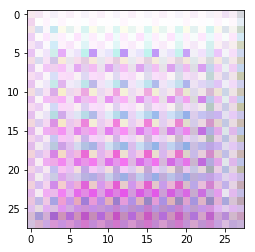

Epoch [6/50], Step [1/40], d_loss: 1.4390, g_loss: 0.8277, D(x): 0.43, D(G(z)): 0.45
Epoch [6/50], Step [2/40], d_loss: 1.4366, g_loss: 0.8392, D(x): 0.43, D(G(z)): 0.44
Epoch [6/50], Step [3/40], d_loss: 1.4306, g_loss: 0.8491, D(x): 0.43, D(G(z)): 0.44
Epoch [6/50], Step [4/40], d_loss: 1.4245, g_loss: 0.8577, D(x): 0.43, D(G(z)): 0.43
Epoch [6/50], Step [5/40], d_loss: 1.4170, g_loss: 0.8646, D(x): 0.43, D(G(z)): 0.43
Epoch [6/50], Step [6/40], d_loss: 1.4050, g_loss: 0.8710, D(x): 0.43, D(G(z)): 0.43
Epoch [6/50], Step [7/40], d_loss: 1.4021, g_loss: 0.8762, D(x): 0.43, D(G(z)): 0.42
Epoch [6/50], Step [8/40], d_loss: 1.3894, g_loss: 0.8800, D(x): 0.43, D(G(z)): 0.42
Epoch [6/50], Step [9/40], d_loss: 1.3835, g_loss: 0.8823, D(x): 0.43, D(G(z)): 0.42
Epoch [6/50], Step [10/40], d_loss: 1.3745, g_loss: 0.8829, D(x): 0.44, D(G(z)): 0.42
Epoch [6/50], Step [11/40], d_loss: 1.3688, g_loss: 0.8818, D(x): 0.44, D(G(z)): 0.42
Epoch [6/50], Step [12/40], d_loss: 1.3643, g_loss: 0.8790, D(x

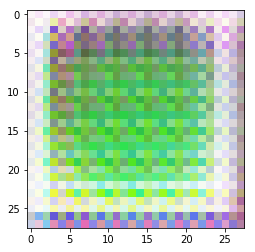

Epoch [7/50], Step [1/40], d_loss: 1.3843, g_loss: 0.8460, D(x): 0.45, D(G(z)): 0.44
Epoch [7/50], Step [2/40], d_loss: 1.3834, g_loss: 0.8484, D(x): 0.45, D(G(z)): 0.44
Epoch [7/50], Step [3/40], d_loss: 1.3822, g_loss: 0.8507, D(x): 0.45, D(G(z)): 0.44
Epoch [7/50], Step [4/40], d_loss: 1.3748, g_loss: 0.8530, D(x): 0.45, D(G(z)): 0.43
Epoch [7/50], Step [5/40], d_loss: 1.3703, g_loss: 0.8544, D(x): 0.45, D(G(z)): 0.43
Epoch [7/50], Step [6/40], d_loss: 1.3660, g_loss: 0.8546, D(x): 0.45, D(G(z)): 0.43
Epoch [7/50], Step [7/40], d_loss: 1.3582, g_loss: 0.8547, D(x): 0.45, D(G(z)): 0.43
Epoch [7/50], Step [8/40], d_loss: 1.3520, g_loss: 0.8543, D(x): 0.46, D(G(z)): 0.43
Epoch [7/50], Step [9/40], d_loss: 1.3458, g_loss: 0.8536, D(x): 0.46, D(G(z)): 0.43
Epoch [7/50], Step [10/40], d_loss: 1.3382, g_loss: 0.8529, D(x): 0.46, D(G(z)): 0.43
Epoch [7/50], Step [11/40], d_loss: 1.3281, g_loss: 0.8513, D(x): 0.47, D(G(z)): 0.43
Epoch [7/50], Step [12/40], d_loss: 1.3222, g_loss: 0.8502, D(x

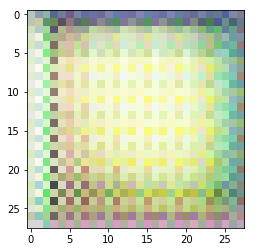

Epoch [8/50], Step [1/40], d_loss: 1.4196, g_loss: 0.5862, D(x): 0.57, D(G(z)): 0.57
Epoch [8/50], Step [2/40], d_loss: 1.4399, g_loss: 0.5769, D(x): 0.57, D(G(z)): 0.58
Epoch [8/50], Step [3/40], d_loss: 1.4487, g_loss: 0.5738, D(x): 0.57, D(G(z)): 0.58
Epoch [8/50], Step [4/40], d_loss: 1.4508, g_loss: 0.5753, D(x): 0.57, D(G(z)): 0.58
Epoch [8/50], Step [5/40], d_loss: 1.4497, g_loss: 0.5789, D(x): 0.56, D(G(z)): 0.58
Epoch [8/50], Step [6/40], d_loss: 1.4467, g_loss: 0.5873, D(x): 0.56, D(G(z)): 0.58
Epoch [8/50], Step [7/40], d_loss: 1.4354, g_loss: 0.5987, D(x): 0.56, D(G(z)): 0.57
Epoch [8/50], Step [8/40], d_loss: 1.4194, g_loss: 0.6128, D(x): 0.56, D(G(z)): 0.56
Epoch [8/50], Step [9/40], d_loss: 1.4043, g_loss: 0.6279, D(x): 0.56, D(G(z)): 0.56
Epoch [8/50], Step [10/40], d_loss: 1.3878, g_loss: 0.6425, D(x): 0.56, D(G(z)): 0.55
Epoch [8/50], Step [11/40], d_loss: 1.3770, g_loss: 0.6555, D(x): 0.55, D(G(z)): 0.54
Epoch [8/50], Step [12/40], d_loss: 1.3684, g_loss: 0.6654, D(x

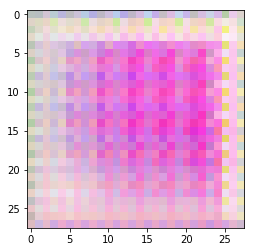

Epoch [9/50], Step [1/40], d_loss: 1.4104, g_loss: 0.8800, D(x): 0.43, D(G(z)): 0.43
Epoch [9/50], Step [2/40], d_loss: 1.4227, g_loss: 0.8863, D(x): 0.42, D(G(z)): 0.43
Epoch [9/50], Step [3/40], d_loss: 1.4249, g_loss: 0.8894, D(x): 0.42, D(G(z)): 0.42
Epoch [9/50], Step [4/40], d_loss: 1.4216, g_loss: 0.8932, D(x): 0.42, D(G(z)): 0.42
Epoch [9/50], Step [5/40], d_loss: 1.4134, g_loss: 0.8981, D(x): 0.42, D(G(z)): 0.41
Epoch [9/50], Step [6/40], d_loss: 1.4061, g_loss: 0.9022, D(x): 0.42, D(G(z)): 0.41
Epoch [9/50], Step [7/40], d_loss: 1.3994, g_loss: 0.9055, D(x): 0.42, D(G(z)): 0.41
Epoch [9/50], Step [8/40], d_loss: 1.3905, g_loss: 0.9073, D(x): 0.43, D(G(z)): 0.41
Epoch [9/50], Step [9/40], d_loss: 1.3839, g_loss: 0.9076, D(x): 0.43, D(G(z)): 0.41
Epoch [9/50], Step [10/40], d_loss: 1.3698, g_loss: 0.9074, D(x): 0.44, D(G(z)): 0.41
Epoch [9/50], Step [11/40], d_loss: 1.3587, g_loss: 0.9071, D(x): 0.44, D(G(z)): 0.41
Epoch [9/50], Step [12/40], d_loss: 1.3523, g_loss: 0.9063, D(x

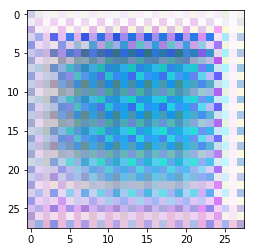

Epoch [10/50], Step [1/40], d_loss: 1.3031, g_loss: 0.8070, D(x): 0.52, D(G(z)): 0.47
Epoch [10/50], Step [2/40], d_loss: 1.3056, g_loss: 0.8201, D(x): 0.51, D(G(z)): 0.46
Epoch [10/50], Step [3/40], d_loss: 1.3014, g_loss: 0.8359, D(x): 0.51, D(G(z)): 0.45
Epoch [10/50], Step [4/40], d_loss: 1.2971, g_loss: 0.8519, D(x): 0.50, D(G(z)): 0.45
Epoch [10/50], Step [5/40], d_loss: 1.2855, g_loss: 0.8666, D(x): 0.50, D(G(z)): 0.44
Epoch [10/50], Step [6/40], d_loss: 1.2797, g_loss: 0.8797, D(x): 0.50, D(G(z)): 0.43
Epoch [10/50], Step [7/40], d_loss: 1.2759, g_loss: 0.8919, D(x): 0.49, D(G(z)): 0.42
Epoch [10/50], Step [8/40], d_loss: 1.2662, g_loss: 0.9029, D(x): 0.49, D(G(z)): 0.42
Epoch [10/50], Step [9/40], d_loss: 1.2634, g_loss: 0.9129, D(x): 0.49, D(G(z)): 0.41
Epoch [10/50], Step [10/40], d_loss: 1.2515, g_loss: 0.9220, D(x): 0.49, D(G(z)): 0.41
Epoch [10/50], Step [11/40], d_loss: 1.2409, g_loss: 0.9308, D(x): 0.49, D(G(z)): 0.41
Epoch [10/50], Step [12/40], d_loss: 1.2339, g_loss:

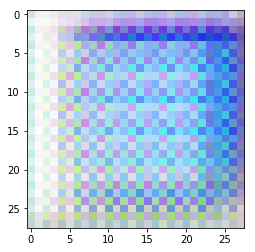

Epoch [11/50], Step [1/40], d_loss: 1.3782, g_loss: 0.7891, D(x): 0.49, D(G(z)): 0.47
Epoch [11/50], Step [2/40], d_loss: 1.3599, g_loss: 0.8062, D(x): 0.49, D(G(z)): 0.46
Epoch [11/50], Step [3/40], d_loss: 1.3486, g_loss: 0.8178, D(x): 0.48, D(G(z)): 0.45
Epoch [11/50], Step [4/40], d_loss: 1.3392, g_loss: 0.8272, D(x): 0.48, D(G(z)): 0.45
Epoch [11/50], Step [5/40], d_loss: 1.3338, g_loss: 0.8341, D(x): 0.48, D(G(z)): 0.45
Epoch [11/50], Step [6/40], d_loss: 1.3371, g_loss: 0.8397, D(x): 0.48, D(G(z)): 0.44
Epoch [11/50], Step [7/40], d_loss: 1.3278, g_loss: 0.8441, D(x): 0.48, D(G(z)): 0.44
Epoch [11/50], Step [8/40], d_loss: 1.3234, g_loss: 0.8476, D(x): 0.48, D(G(z)): 0.44
Epoch [11/50], Step [9/40], d_loss: 1.3218, g_loss: 0.8498, D(x): 0.48, D(G(z)): 0.44
Epoch [11/50], Step [10/40], d_loss: 1.3127, g_loss: 0.8523, D(x): 0.48, D(G(z)): 0.44
Epoch [11/50], Step [11/40], d_loss: 1.3028, g_loss: 0.8558, D(x): 0.49, D(G(z)): 0.44
Epoch [11/50], Step [12/40], d_loss: 1.2951, g_loss:

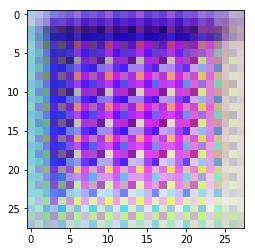

Epoch [12/50], Step [1/40], d_loss: 1.2789, g_loss: 0.7543, D(x): 0.55, D(G(z)): 0.48
Epoch [12/50], Step [2/40], d_loss: 1.2779, g_loss: 0.7465, D(x): 0.55, D(G(z)): 0.49
Epoch [12/50], Step [3/40], d_loss: 1.2788, g_loss: 0.7393, D(x): 0.55, D(G(z)): 0.49
Epoch [12/50], Step [4/40], d_loss: 1.2772, g_loss: 0.7334, D(x): 0.56, D(G(z)): 0.49
Epoch [12/50], Step [5/40], d_loss: 1.2793, g_loss: 0.7295, D(x): 0.56, D(G(z)): 0.50
Epoch [12/50], Step [6/40], d_loss: 1.2922, g_loss: 0.7256, D(x): 0.56, D(G(z)): 0.50
Epoch [12/50], Step [7/40], d_loss: 1.2918, g_loss: 0.7226, D(x): 0.56, D(G(z)): 0.50
Epoch [12/50], Step [8/40], d_loss: 1.2867, g_loss: 0.7197, D(x): 0.56, D(G(z)): 0.50
Epoch [12/50], Step [9/40], d_loss: 1.2952, g_loss: 0.7174, D(x): 0.56, D(G(z)): 0.50
Epoch [12/50], Step [10/40], d_loss: 1.2904, g_loss: 0.7145, D(x): 0.56, D(G(z)): 0.51
Epoch [12/50], Step [11/40], d_loss: 1.2913, g_loss: 0.7130, D(x): 0.57, D(G(z)): 0.51
Epoch [12/50], Step [12/40], d_loss: 1.2923, g_loss:

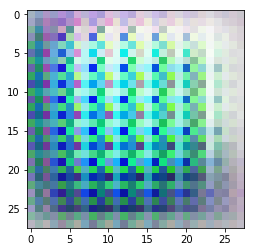

Epoch [13/50], Step [1/40], d_loss: 1.1332, g_loss: 0.7774, D(x): 0.62, D(G(z)): 0.47
Epoch [13/50], Step [2/40], d_loss: 1.1525, g_loss: 0.7755, D(x): 0.62, D(G(z)): 0.48
Epoch [13/50], Step [3/40], d_loss: 1.1473, g_loss: 0.7737, D(x): 0.62, D(G(z)): 0.47
Epoch [13/50], Step [4/40], d_loss: 1.1523, g_loss: 0.7739, D(x): 0.62, D(G(z)): 0.47
Epoch [13/50], Step [5/40], d_loss: 1.1474, g_loss: 0.7778, D(x): 0.62, D(G(z)): 0.47
Epoch [13/50], Step [6/40], d_loss: 1.1487, g_loss: 0.7796, D(x): 0.62, D(G(z)): 0.47
Epoch [13/50], Step [7/40], d_loss: 1.1560, g_loss: 0.7790, D(x): 0.61, D(G(z)): 0.47
Epoch [13/50], Step [8/40], d_loss: 1.1483, g_loss: 0.7852, D(x): 0.61, D(G(z)): 0.47
Epoch [13/50], Step [9/40], d_loss: 1.1509, g_loss: 0.7907, D(x): 0.61, D(G(z)): 0.47
Epoch [13/50], Step [10/40], d_loss: 1.1380, g_loss: 0.7946, D(x): 0.61, D(G(z)): 0.47
Epoch [13/50], Step [11/40], d_loss: 1.1347, g_loss: 0.8062, D(x): 0.61, D(G(z)): 0.46
Epoch [13/50], Step [12/40], d_loss: 1.1213, g_loss:

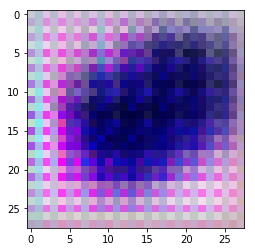

Epoch [14/50], Step [1/40], d_loss: 0.9875, g_loss: 0.9883, D(x): 0.67, D(G(z)): 0.42
Epoch [14/50], Step [2/40], d_loss: 0.9985, g_loss: 1.0031, D(x): 0.66, D(G(z)): 0.42
Epoch [14/50], Step [3/40], d_loss: 1.0094, g_loss: 1.0100, D(x): 0.65, D(G(z)): 0.41
Epoch [14/50], Step [4/40], d_loss: 1.0087, g_loss: 1.0285, D(x): 0.65, D(G(z)): 0.41
Epoch [14/50], Step [5/40], d_loss: 1.0032, g_loss: 1.0467, D(x): 0.64, D(G(z)): 0.40
Epoch [14/50], Step [6/40], d_loss: 1.0040, g_loss: 1.0795, D(x): 0.63, D(G(z)): 0.39
Epoch [14/50], Step [7/40], d_loss: 0.9948, g_loss: 1.0955, D(x): 0.63, D(G(z)): 0.39
Epoch [14/50], Step [8/40], d_loss: 0.9888, g_loss: 1.1189, D(x): 0.62, D(G(z)): 0.38
Epoch [14/50], Step [9/40], d_loss: 0.9777, g_loss: 1.1417, D(x): 0.62, D(G(z)): 0.36
Epoch [14/50], Step [10/40], d_loss: 0.9635, g_loss: 1.1720, D(x): 0.62, D(G(z)): 0.36
Epoch [14/50], Step [11/40], d_loss: 0.9404, g_loss: 1.1907, D(x): 0.62, D(G(z)): 0.35
Epoch [14/50], Step [12/40], d_loss: 0.9333, g_loss:

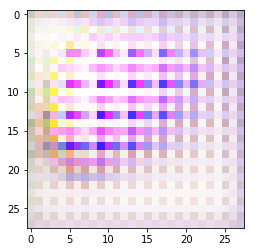

Epoch [15/50], Step [1/40], d_loss: 1.2263, g_loss: 0.8866, D(x): 0.63, D(G(z)): 0.50
Epoch [15/50], Step [2/40], d_loss: 1.3157, g_loss: 0.8509, D(x): 0.60, D(G(z)): 0.52
Epoch [15/50], Step [3/40], d_loss: 1.3751, g_loss: 0.8345, D(x): 0.58, D(G(z)): 0.53
Epoch [15/50], Step [4/40], d_loss: 1.4350, g_loss: 0.8305, D(x): 0.55, D(G(z)): 0.53
Epoch [15/50], Step [5/40], d_loss: 1.4555, g_loss: 0.8496, D(x): 0.53, D(G(z)): 0.52
Epoch [15/50], Step [6/40], d_loss: 1.4507, g_loss: 0.8905, D(x): 0.51, D(G(z)): 0.51
Epoch [15/50], Step [7/40], d_loss: 1.4484, g_loss: 0.9344, D(x): 0.49, D(G(z)): 0.48
Epoch [15/50], Step [8/40], d_loss: 1.4602, g_loss: 0.9682, D(x): 0.47, D(G(z)): 0.47
Epoch [15/50], Step [9/40], d_loss: 1.4508, g_loss: 0.9853, D(x): 0.47, D(G(z)): 0.45
Epoch [15/50], Step [10/40], d_loss: 1.4681, g_loss: 0.9844, D(x): 0.46, D(G(z)): 0.45
Epoch [15/50], Step [11/40], d_loss: 1.5037, g_loss: 0.9687, D(x): 0.45, D(G(z)): 0.45
Epoch [15/50], Step [12/40], d_loss: 1.5238, g_loss:

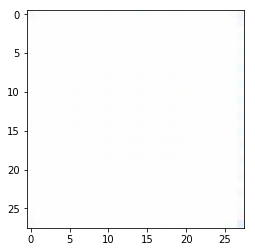

Epoch [16/50], Step [1/40], d_loss: 0.4959, g_loss: 2.0068, D(x): 0.72, D(G(z)): 0.14
Epoch [16/50], Step [2/40], d_loss: 0.5045, g_loss: 1.9692, D(x): 0.72, D(G(z)): 0.14
Epoch [16/50], Step [3/40], d_loss: 0.4928, g_loss: 1.8883, D(x): 0.74, D(G(z)): 0.15
Epoch [16/50], Step [4/40], d_loss: 0.5239, g_loss: 1.6555, D(x): 0.75, D(G(z)): 0.19
Epoch [16/50], Step [5/40], d_loss: 0.6256, g_loss: 1.3017, D(x): 0.76, D(G(z)): 0.28
Epoch [16/50], Step [6/40], d_loss: 0.7619, g_loss: 1.0220, D(x): 0.77, D(G(z)): 0.38
Epoch [16/50], Step [7/40], d_loss: 0.8654, g_loss: 0.8945, D(x): 0.77, D(G(z)): 0.43
Epoch [16/50], Step [8/40], d_loss: 0.9162, g_loss: 0.8542, D(x): 0.78, D(G(z)): 0.46
Epoch [16/50], Step [9/40], d_loss: 0.9304, g_loss: 0.8487, D(x): 0.78, D(G(z)): 0.47
Epoch [16/50], Step [10/40], d_loss: 0.9174, g_loss: 0.8757, D(x): 0.78, D(G(z)): 0.46
Epoch [16/50], Step [11/40], d_loss: 0.9054, g_loss: 0.9178, D(x): 0.78, D(G(z)): 0.45
Epoch [16/50], Step [12/40], d_loss: 0.8818, g_loss:

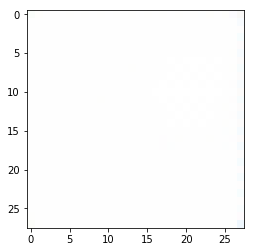

Epoch [17/50], Step [1/40], d_loss: 0.3544, g_loss: 1.9013, D(x): 0.86, D(G(z)): 0.17
Epoch [17/50], Step [2/40], d_loss: 0.3733, g_loss: 1.8985, D(x): 0.85, D(G(z)): 0.17
Epoch [17/50], Step [3/40], d_loss: 0.3648, g_loss: 1.8877, D(x): 0.85, D(G(z)): 0.17
Epoch [17/50], Step [4/40], d_loss: 0.3642, g_loss: 1.8892, D(x): 0.85, D(G(z)): 0.17
Epoch [17/50], Step [5/40], d_loss: 0.3676, g_loss: 1.8849, D(x): 0.85, D(G(z)): 0.17
Epoch [17/50], Step [6/40], d_loss: 0.3621, g_loss: 1.8709, D(x): 0.86, D(G(z)): 0.18
Epoch [17/50], Step [7/40], d_loss: 0.3769, g_loss: 1.8544, D(x): 0.85, D(G(z)): 0.18
Epoch [17/50], Step [8/40], d_loss: 0.3783, g_loss: 1.8212, D(x): 0.86, D(G(z)): 0.19
Epoch [17/50], Step [9/40], d_loss: 0.3952, g_loss: 1.7967, D(x): 0.85, D(G(z)): 0.19
Epoch [17/50], Step [10/40], d_loss: 0.4049, g_loss: 1.7605, D(x): 0.85, D(G(z)): 0.20
Epoch [17/50], Step [11/40], d_loss: 0.4215, g_loss: 1.7469, D(x): 0.85, D(G(z)): 0.21
Epoch [17/50], Step [12/40], d_loss: 0.4239, g_loss:

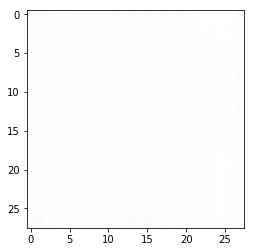

Epoch [18/50], Step [1/40], d_loss: 0.2718, g_loss: 1.9920, D(x): 0.93, D(G(z)): 0.17
Epoch [18/50], Step [2/40], d_loss: 0.2771, g_loss: 2.0439, D(x): 0.92, D(G(z)): 0.17
Epoch [18/50], Step [3/40], d_loss: 0.2659, g_loss: 2.1133, D(x): 0.92, D(G(z)): 0.16
Epoch [18/50], Step [4/40], d_loss: 0.2581, g_loss: 2.2018, D(x): 0.91, D(G(z)): 0.15
Epoch [18/50], Step [5/40], d_loss: 0.2462, g_loss: 2.3164, D(x): 0.91, D(G(z)): 0.13
Epoch [18/50], Step [6/40], d_loss: 0.2284, g_loss: 2.4520, D(x): 0.90, D(G(z)): 0.11
Epoch [18/50], Step [7/40], d_loss: 0.2269, g_loss: 2.6111, D(x): 0.89, D(G(z)): 0.09
Epoch [18/50], Step [8/40], d_loss: 0.2069, g_loss: 2.7714, D(x): 0.89, D(G(z)): 0.08
Epoch [18/50], Step [9/40], d_loss: 0.2121, g_loss: 2.9233, D(x): 0.88, D(G(z)): 0.07
Epoch [18/50], Step [10/40], d_loss: 0.2002, g_loss: 3.0491, D(x): 0.88, D(G(z)): 0.06
Epoch [18/50], Step [11/40], d_loss: 0.2023, g_loss: 3.1504, D(x): 0.87, D(G(z)): 0.05
Epoch [18/50], Step [12/40], d_loss: 0.2020, g_loss:

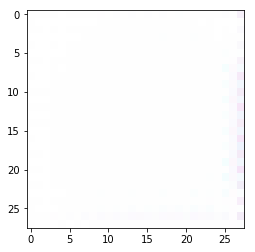

Epoch [19/50], Step [1/40], d_loss: 0.0532, g_loss: 3.6079, D(x): 0.98, D(G(z)): 0.03
Epoch [19/50], Step [2/40], d_loss: 0.0524, g_loss: 3.6451, D(x): 0.98, D(G(z)): 0.03
Epoch [19/50], Step [3/40], d_loss: 0.0501, g_loss: 3.6813, D(x): 0.98, D(G(z)): 0.03
Epoch [19/50], Step [4/40], d_loss: 0.0480, g_loss: 3.7183, D(x): 0.98, D(G(z)): 0.03
Epoch [19/50], Step [5/40], d_loss: 0.0477, g_loss: 3.7603, D(x): 0.98, D(G(z)): 0.03
Epoch [19/50], Step [6/40], d_loss: 0.0456, g_loss: 3.7898, D(x): 0.98, D(G(z)): 0.02
Epoch [19/50], Step [7/40], d_loss: 0.0467, g_loss: 3.8227, D(x): 0.98, D(G(z)): 0.02
Epoch [19/50], Step [8/40], d_loss: 0.0435, g_loss: 3.8515, D(x): 0.98, D(G(z)): 0.02
Epoch [19/50], Step [9/40], d_loss: 0.0452, g_loss: 3.8844, D(x): 0.98, D(G(z)): 0.02
Epoch [19/50], Step [10/40], d_loss: 0.0435, g_loss: 3.9013, D(x): 0.98, D(G(z)): 0.02
Epoch [19/50], Step [11/40], d_loss: 0.0435, g_loss: 3.9176, D(x): 0.98, D(G(z)): 0.02
Epoch [19/50], Step [12/40], d_loss: 0.0437, g_loss:

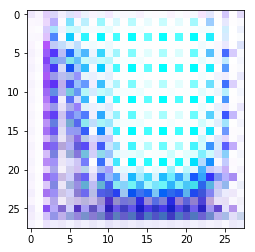

Epoch [20/50], Step [1/40], d_loss: 0.7249, g_loss: 1.8179, D(x): 0.72, D(G(z)): 0.28
Epoch [20/50], Step [2/40], d_loss: 0.7773, g_loss: 1.9512, D(x): 0.66, D(G(z)): 0.24
Epoch [20/50], Step [3/40], d_loss: 0.8434, g_loss: 2.0101, D(x): 0.61, D(G(z)): 0.21
Epoch [20/50], Step [4/40], d_loss: 0.8887, g_loss: 2.0086, D(x): 0.59, D(G(z)): 0.21
Epoch [20/50], Step [5/40], d_loss: 0.9627, g_loss: 1.9698, D(x): 0.56, D(G(z)): 0.21
Epoch [20/50], Step [6/40], d_loss: 1.0190, g_loss: 1.8827, D(x): 0.54, D(G(z)): 0.21
Epoch [20/50], Step [7/40], d_loss: 1.0879, g_loss: 1.7761, D(x): 0.52, D(G(z)): 0.23
Epoch [20/50], Step [8/40], d_loss: 1.0950, g_loss: 1.6324, D(x): 0.54, D(G(z)): 0.26
Epoch [20/50], Step [9/40], d_loss: 1.1588, g_loss: 1.5013, D(x): 0.54, D(G(z)): 0.29
Epoch [20/50], Step [10/40], d_loss: 1.1659, g_loss: 1.3385, D(x): 0.56, D(G(z)): 0.33
Epoch [20/50], Step [11/40], d_loss: 1.2152, g_loss: 1.1869, D(x): 0.57, D(G(z)): 0.37
Epoch [20/50], Step [12/40], d_loss: 1.2557, g_loss:

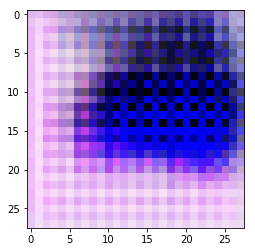

Epoch [21/50], Step [1/40], d_loss: 1.1805, g_loss: 1.5662, D(x): 0.55, D(G(z)): 0.29
Epoch [21/50], Step [2/40], d_loss: 1.1034, g_loss: 1.6345, D(x): 0.57, D(G(z)): 0.28
Epoch [21/50], Step [3/40], d_loss: 1.0361, g_loss: 1.6766, D(x): 0.58, D(G(z)): 0.25
Epoch [21/50], Step [4/40], d_loss: 0.9796, g_loss: 1.7433, D(x): 0.60, D(G(z)): 0.24
Epoch [21/50], Step [5/40], d_loss: 0.9463, g_loss: 1.7658, D(x): 0.60, D(G(z)): 0.23
Epoch [21/50], Step [6/40], d_loss: 0.9097, g_loss: 1.7893, D(x): 0.61, D(G(z)): 0.22
Epoch [21/50], Step [7/40], d_loss: 0.8442, g_loss: 1.8240, D(x): 0.64, D(G(z)): 0.21
Epoch [21/50], Step [8/40], d_loss: 0.8129, g_loss: 1.8354, D(x): 0.65, D(G(z)): 0.22
Epoch [21/50], Step [9/40], d_loss: 0.7624, g_loss: 1.8553, D(x): 0.67, D(G(z)): 0.21
Epoch [21/50], Step [10/40], d_loss: 0.7039, g_loss: 1.8626, D(x): 0.70, D(G(z)): 0.21
Epoch [21/50], Step [11/40], d_loss: 0.6581, g_loss: 1.8647, D(x): 0.73, D(G(z)): 0.21
Epoch [21/50], Step [12/40], d_loss: 0.6359, g_loss:

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

num_epochs = 50

batch_size = 5000

# Start training
total_step = len(preloaded_data) // batch_size
for epoch in range(num_epochs):
    for i in range(total_step):
        images = preloaded_data[batch_size * i : batch_size * (i+1)]
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, *latent_shape).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        del d_loss_real, d_loss_fake
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, *latent_shape).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # if (i+1) % 200 == 0:
        print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        del d_loss, g_loss
    
    # Save the model checkpoints 
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

    # Save real images
    if (epoch+1) == 1:
        image = denorm(images).cpu().numpy()[0]
        plt.figure()
        plt.imshow(np.moveaxis(image, 0, -1))
        plt.show()
    
    # Save sampled images
    image = denorm(fake_images).cpu().detach().numpy()[0]
    plt.figure()
    plt.imshow(np.moveaxis(image, 0, -1))
    plt.show()
